<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/sala_de_premsa/noticies/2016/202-nova-marca-uoc.jpg", align="left" width="380" height="120">

</div>
</div>
<div style="float: right; width: 50%;">
<p>&nbsp;</p>
<p style="margin: 0; padding-top: 22px; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Máster en Ciencia de Datos</p>
<p style="margin: 0; text-align:right;">&nbsp;&nbsp;&nbsp;&nbsp;Área 2: Machine Learning in Cybersecurity</p>
<p>&nbsp;</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<p><b>Desafíos y optimización en sistemas de detección de intrusiones (IDS) basados en comportamiento</b></p>
<p><i><b>Autor: </b>Ivan Benaiges Trenchs</i></p>
<p><i><b>Tutor/a de TF: </b>Blas Torregrosa Garcia</i></p>
<p><i><b>Profesor/a responsable de la asignatura: </b>JosepAnton Mir Tutusaus</i></p>

# Modelo actualizado por ventanas deslizantes

Durante el transcurso de este notebook sse ha desarrollado y evaluado un modelo basado en la técnica de ventanas deslizantes. Esta técnica consiste en entrenar un modelo usando un subconjunto de datos y luego desplazar dicha ventana hacia adelante en el tiempo para volver a entrenar o actualizar el modelo con nuevos datos parcialmente superpuestos. Esta técnica permite capturar la evolución temporal de la información sin usar todo el histórico a la vez, dando como resultado varios modelos entrenados con intervalos secuenciales.

No obstante, este enfoque tiene como gran handicap que no se realiza un aprendizaje incremental al uso, simplemente se crea otro modelo entrenado desde cero con la última ventana de datos. Esto puede provocar que se pierda conocimiento previo y que los resultados no sean buenos a la larga para patrones de ataque que se correspondan con técnicas antiguas, pero que puedan seguir usándose en la actualidad.

## Paso 1: Importar librerías

In [1]:
# Importamos las librerías a utilizar a lo largo de este Notebook:
import tensorflow as tf
import platform
import psutil
import os
import time
import random
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, BatchNormalization
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Paso 2: Obtener información del entorno de ejecución

Para llevar a cabo este proyecto se ha usado el entorno Google Colab configurado par ausar CPU con alta capacidad de RAM.

In [2]:
# Información de TensorFlow y Python
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {platform.python_version()}")

# Información de GPU
gpu_info = os.popen("nvidia-smi --query-gpu=gpu_name,memory.total --format=csv").read()
print("GPU Info:\n", gpu_info)

# Información de CPU
cpu_info = os.popen("lscpu").read()
print("CPU Info:\n", cpu_info)

# Información de RAM
ram = psutil.virtual_memory()
print(f"RAM Total: {ram.total / 1e9:.2f} GB")

TensorFlow version: 2.17.1
Python version: 3.10.12
GPU Info:
 
CPU Info:
 Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        48 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               8
On-line CPU(s) list:                  0-7
Vendor ID:                            AuthenticAMD
Model name:                           AMD EPYC 7B12
CPU family:                           23
Model:                                49
Thread(s) per core:                   2
Core(s) per socket:                   4
Socket(s):                            1
Stepping:                             0
BogoMIPS:                             4499.99
Flags:                                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid ex

## Paso 3: Definiciones previas a la creación del modelo

In [3]:
# Cargaremos los ficheros que conforman el dataset des de nuestro Google Drive:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Definimos la ruta de la carpeta donde están los ficheros CSV con los conjuntos de datos:
dataset_folder = "/content/drive/My Drive/TFM - DS/output_datasets/"

# Obtenemos la lista de ficheros CSV que hay en la carpeta:
csv_files = [f for f in os.listdir(dataset_folder) if f.endswith('.csv')]
print(csv_files)

['02-14-2018_train.csv', '02-14-2018_val.csv', '02-14-2018_test.csv', '02-15-2018_val.csv', '02-15-2018_train.csv', '02-15-2018_test.csv', '02-16-2018_train.csv', '02-16-2018_val.csv', '02-16-2018_test.csv', '02-20-2018_train.csv', '02-20-2018_val.csv', '02-20-2018_test.csv', '02-21-2018_train.csv', '02-21-2018_test.csv', '02-21-2018_val.csv', '02-23-2018_train.csv', '02-23-2018_val.csv', '02-22-2018_test.csv', '02-22-2018_train.csv', '02-22-2018_val.csv', '02-23-2018_test.csv', '02-28-2018_test.csv', '02-28-2018_val.csv', '02-28-2018_train.csv', '03-01-2018_test.csv', '03-01-2018_val.csv', '03-01-2018_train.csv', '03-02-2018_train.csv', '03-02-2018_test.csv', '03-02-2018_val.csv', 'evaluation_results.csv']


In [5]:
# Generamos la ruta donde guardaremos los resultados:
save_dir = os.path.join(dataset_folder, 'static_window_model')
os.makedirs(save_dir, exist_ok=True)

In [6]:
# Generamos variables para poder gestionar mejor los conjuntos de entrenamiento, validación y test:
train_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_train.csv')])
val_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_val.csv')])
test_files = sorted([f for f in os.listdir(dataset_folder) if f.endswith('_test.csv')])

print("Archivos de entrenamiento:", train_files)
print("Archivos de validación:", val_files)
print("Archivos de prueba:", test_files)

# Verificamos que el número de archivos coincida y no haya ningún problema:
if not (len(train_files) == len(val_files) == len(test_files)):
    raise ValueError("El número de archivos de entrenamiento, validación y prueba no coincide.")

# Comprobamos el número total de días:
num_days = len(train_files)
print(f"Total de días en el dataset: {num_days} días")

Archivos de entrenamiento: ['02-14-2018_train.csv', '02-15-2018_train.csv', '02-16-2018_train.csv', '02-20-2018_train.csv', '02-21-2018_train.csv', '02-22-2018_train.csv', '02-23-2018_train.csv', '02-28-2018_train.csv', '03-01-2018_train.csv', '03-02-2018_train.csv']
Archivos de validación: ['02-14-2018_val.csv', '02-15-2018_val.csv', '02-16-2018_val.csv', '02-20-2018_val.csv', '02-21-2018_val.csv', '02-22-2018_val.csv', '02-23-2018_val.csv', '02-28-2018_val.csv', '03-01-2018_val.csv', '03-02-2018_val.csv']
Archivos de prueba: ['02-14-2018_test.csv', '02-15-2018_test.csv', '02-16-2018_test.csv', '02-20-2018_test.csv', '02-21-2018_test.csv', '02-22-2018_test.csv', '02-23-2018_test.csv', '02-28-2018_test.csv', '03-01-2018_test.csv', '03-02-2018_test.csv']
Total de días en el dataset: 10 días


In [7]:
# Comprobamos que la información de los ficheros de los diferentes días es correcta:
for day in range(len(train_files)):
    train_file = os.path.join(dataset_folder, train_files[day])
    train_df = pd.read_csv(train_file)
    class_counts = train_df['Label'].value_counts()
    print(f"Día {day + 1} - Distribución de Clases:\n{class_counts}\n")

Día 1 - Distribución de Clases:
Label
Malicious    266660
Benign       266660
Name: count, dtype: int64

Día 2 - Distribución de Clases:
Label
Benign       36748
Malicious    36748
Name: count, dtype: int64

Día 3 - Distribución de Clases:
Label
Benign       312740
Malicious    312740
Name: count, dtype: int64

Día 4 - Distribución de Clases:
Label
Benign       403333
Malicious    403333
Name: count, dtype: int64

Día 5 - Distribución de Clases:
Label
Benign       252583
Malicious    252583
Name: count, dtype: int64

Día 6 - Distribución de Clases:
Label
Benign       253
Malicious    253
Name: count, dtype: int64

Día 7 - Distribución de Clases:
Label
Malicious    396
Benign       396
Name: count, dtype: int64

Día 8 - Distribución de Clases:
Label
Benign       47765
Malicious    47765
Name: count, dtype: int64

Día 9 - Distribución de Clases:
Label
Malicious    64682
Benign       64682
Name: count, dtype: int64

Día 10 - Distribución de Clases:
Label
Malicious    200333
Benign       2

In [8]:
# Definimos las semillas para poder obtener resultados reproducibles:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Paso 4: Ajuste global del escalado y de las etiquetas

Debido a la gran cantidad de datos diferentes entre los días que conforman el dataset completo y para evitar problemas al tener escalados diferentes según el día y tipo de ataque, se ha decidido, debido a tratarse de un trabajo de investigación y prueba de diferentes modelos y enfoques, preparar un objeto que realice el escalado basado en el conjunto total de los datos.

No obstante, este punto podría haberse obviado para para analizar lo que esto conllevaría en un modelo real que estuviera en producción como, por ejemplo, el clasificar incorrectamente algunas muestras debido a un escalado que no tuviera en cuenta el conjunto global de los datos.

Por otro lado, pensando en un futuro trabajo basado en un modelo multiclase, se mantiene también la caracterización de las etiquetas a nivel global. Nuevamente, esto podría ser contraproducente para demostrar las carencias de este enfoque estático.

In [9]:
# Ajustamos el MinMaxScaler globalmente con todos los datos de entrenamiento:
print("\nAjustando el MinMaxScaler globalmente con todos los datos de entrenamiento...")
all_train_X = []

for train_file in train_files:
    train_path = os.path.join(dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    X_train_day = train_df.drop(columns=['Label']).values
    all_train_X.append(X_train_day)

# Concatenamos todos los datos de entrenamiento:
all_train_X = np.vstack(all_train_X)
print(f"Forma de todos los datos de entrenamiento concatenados: {all_train_X.shape}")

# Inicializamos y ajustamos el scaler:
scaler = MinMaxScaler()
scaler.fit(all_train_X)
print("MinMaxScaler ajustado globalmente.")


Ajustando el MinMaxScaler globalmente con todos los datos de entrenamiento...
Forma de todos los datos de entrenamiento concatenados: (3170986, 78)
MinMaxScaler ajustado globalmente.


In [10]:
# Inicializamos y ajustamos el LabelEncoder con todas las clases. Debido a que las clases son conocidas y fijas ajustamos solo una vez:
print("\nAjustando el LabelEncoder con todas las clases posibles...")
all_classes = set()
for train_file in train_files:
    train_path = os.path.join(dataset_folder, train_file)
    train_df = pd.read_csv(train_path)
    all_classes.update(train_df['Label'].unique())

label_encoder = LabelEncoder()
label_encoder.fit(list(all_classes))
print(f"Clases encontradas: {label_encoder.classes_}\n")


Ajustando el LabelEncoder con todas las clases posibles...
Clases encontradas: ['Benign' 'Malicious']



## Paso 5: Creación del modelo

En este modelo se reutilizará la arquitectura híbrida CNN-LSTM vista en el modelo estático, adaptándola a un enfoque de ventanas deslizantes en el que se generará un model estático con una duración de 5 días para el entrenamiento y un desplazamiento de 2 días entre una ventana y otra.

Este notebook busca evaluar los puntos fuertes y débiles de este enfoque respecto al modelo estático y al modelo de aprendizaje incremental.

In [11]:
# Definimos el tamaño de la ventana y el stride:
window_size = 5
stride = 2

In [12]:
# Creamos una función para entrenar el modelo dada una ventana de datos:
def train_model_for_window(train_df, val_df, test_df, window_id):
    # Separamos las características y las etiquetas:
    X_train = train_df.drop(columns=['Label']).values
    y_train = train_df['Label'].values

    X_val = val_df.drop(columns=['Label']).values
    y_val = val_df['Label'].values

    X_test = test_df.drop(columns=['Label']).values
    y_test = test_df['Label'].values

    # Codificamos las etiquetas:
    y_train_encoded = label_encoder.transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    n_classes = len(label_encoder.classes_)
    print(f"Número de clases: {n_classes}")
    print(f"Clases: {label_encoder.classes_}")

    n_features = X_train.shape[1]

    # Escalamos los datos:
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Añadimos una dimensión extra para poder usar capas Conv1D:
    X_train_reshaped = X_train_scaled[..., np.newaxis]
    X_val_reshaped = X_val_scaled[..., np.newaxis]
    X_test_reshaped = X_test_scaled[..., np.newaxis]

    # Definimos el modelo en base al modelo estático:
    model = Sequential(name=f'cnn_lstm_window_{window_id}')

    # 1. Capa de entrada:
    model.add(Input(shape=(n_features, 1), name='input'))

    # 2. Capas convolucionales con maxpooling y batch normalization:
    model.add(Dense(8, activation='relu', kernel_regularizer=l2(1e-3), name='dense_1'))
    model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-3), name='conv1d_1'))
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_3'))
    model.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(1e-3), name='conv1d_4'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_2'))
    model.add(BatchNormalization(name='batchnorm_1'))

    # 3. Capa LSTM:
    model.add(LSTM(50, return_sequences=False, kernel_regularizer=l2(1e-3), name='lstm'))

    # 4. Capas densas completamente conectadas:
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_2'))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_3'))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-3), name='dense_4'))
    model.add(Dropout(0.3, name='dropout_1'))

    # 5. Capa de salida binaria:
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-3), name='output'))

    # Compilamos el modelo:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    model.summary()

    # Creamos un conjunto de callbacks para la optimización:
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, f'cnn-lstm_window_{window_id}.keras'), monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

    # Mediremos el tiempo de entrenamiento:
    start_time = time.time()

    # Realizamos el entrenamiento del modelo:
    history = model.fit(
        X_train_reshaped, y_train_encoded,
        validation_data=(X_val_reshaped, y_val_encoded),
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )

    # Calculamos el tiempo total de entrenamiento:
    end_time = time.time()
    training_time = end_time - start_time

    print()
    print(f"Tiempo total de entrenamiento ventana {window_id}: {training_time / 60:.2f} minutos")

    # Cargamos el mejor modelo guardado para hacer la evaluación del mismo:
    model = load_model(os.path.join(save_dir, f'cnn-lstm_window_{window_id}.keras'))

    # Comprobamos los resultados obtenidos por el modelo con el conjunto de test:
    loss, accuracy, precision, recall = model.evaluate(X_test_reshaped, y_test_encoded)
    print(f"Ventana {window_id} - Pérdida en prueba: {loss}")
    print(f"Ventana {window_id} - Exactitud en prueba: {accuracy}")
    print(f"Ventana {window_id} - Precisión en prueba: {precision}")
    print(f"Ventana {window_id} - Recall en prueba: {recall}")

    # Creamos el plot de pérdida del entrenamiento:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    # Creamos el plot de precisión del entrenamiento:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

    # Obtenemos las predicciones del modelo por probabilidad y convertimos los resultados a etiquetas binarias (0 o 1):
    y_pred_proba = model.predict(X_test_reshaped)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Confirmar que las etiquetas incluyen todas las clases:
    all_classes = label_encoder.classes_
    n_classes = len(all_classes)

    # Generamos la matriz de confusión:
    conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=range(n_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix - Ventana " + str(window_id))
    plt.show()

    # Generamos el informe de clasificación:
    print("\nInforme de clasificación:")
    print(classification_report(y_test_encoded, y_pred, target_names=all_classes, labels=range(n_classes), zero_division=0))

    # Creamos las variables que contendrán los resultados del análisis de FP y FN:
    false_positives_by_class = {}
    false_negatives_by_class = {}

    # Calculamos los falsos positivos (FP) y los falsos negativos (FN) respecto a la propia clase:
    for i, class_name in enumerate(all_classes):
        # Calculamos el total de predicciones y verdaderos:
        total_predicted_for_class = np.sum(conf_matrix[:, i])
        total_actual_for_class = np.sum(conf_matrix[i, :])

        # Falsos Positivos (FP):
        fp = total_predicted_for_class - conf_matrix[i, i]
        fp_percentage = (fp / total_predicted_for_class) * 100 if total_predicted_for_class > 0 else 0

        # Falsos Negativos (FN):
        fn = total_actual_for_class - conf_matrix[i, i]
        fn_percentage = (fn / total_actual_for_class) * 100 if total_actual_for_class > 0 else 0

        # Guardamos los resultados:
        false_positives_by_class[class_name] = (fp, fp_percentage)
        false_negatives_by_class[class_name] = (fn, fn_percentage)

    # Mostramos resultados junto con el porcentaje respecto a la propia clase:
    print("Falsos Positivos por clase (respecto a la clase):")
    for class_name, (fp, fp_percentage) in false_positives_by_class.items():
        print(f"{class_name}: {fp} ({fp_percentage:.2f}%)")

    print("\nFalsos Negativos por clase (respecto a la clase):")
    for class_name, (fn, fn_percentage) in false_negatives_by_class.items():
        print(f"{class_name}: {fn} ({fn_percentage:.2f}%)")

    # Calculamos la curva ROC y el valor de AUC:
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Graficamos la curva ROC:
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")

    # Añadimos la línea de referencia:
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("Ratio de falsos positivos (FP)")
    plt.ylabel("Ratio de verdaderos positivos (TP)")
    plt.title("Curva ROC - Ventana " + str(window_id))
    plt.legend(loc="lower right")
    plt.show()

    return model

## Paso 6: Entrenamiento y evaluación de los modelos en los conjuntos de validación y de test

En esta fase se generarán los diferentes conjuntos de datos basados en las ventanas deslizantes definidas (conjuntos de 5 días con un desplazamiento de 2), de forma que se entrenarán tantos modelos como entren en esta configuración. Estos se utilizarán para entrenar un nuevo modelo que solo utilizará los datos de entrenamiento correspondientes.

Teniendo en cuenta que tenemos datos de 10 días, se generarán 3 modelos diferentes: uno para los días 1 a 5, otro para los días 3 a 7 y un último para los días 5 a 9.


=== Entrenando modelo para ventana 1 (días 1 a 5) ===
Número de clases: 2
Clases: ['Benign' 'Malicious']


Model: "cnn_lstm_window_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 78, 8)               │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 76, 16)              │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 38, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 36, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 34, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 17, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 17, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,473 (91.69 KB)

 Trainable params: 23,409 (91.44 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
39748/39752 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.9849 - Recall: 0.9893 - accuracy: 0.9871 - loss: 0.0986
Epoch 1: val_accuracy improved from -inf to 0.95175, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_1.keras
39752/39752 ━━━━━━━━━━━━━━━━━━━━ 446s 11ms/step - Precision: 0.9849 - Recall: 0.9893 - accuracy: 0.9871 - loss: 0.0986 - val_Precision: 0.9930 - val_Recall: 0.9099 - val_accuracy: 0.9517 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 2/20
39749/39752 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.9915 - Recall: 0.9945 - accuracy: 0.9930 - loss: 0.0560
Epoch 2: val_accuracy improved from 0.95175 to 0.98764, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_1.keras
39752/39752 ━━━━━━━━━━━━━━━━━━━━ 445s 11ms/step - Precision: 0.9915 - Recall: 0.9945 - accuracy: 0.9930 - loss: 0.0560 - val_Precision: 0.9950 - val_Recall: 0.9802 - val_accuracy: 0.9876 

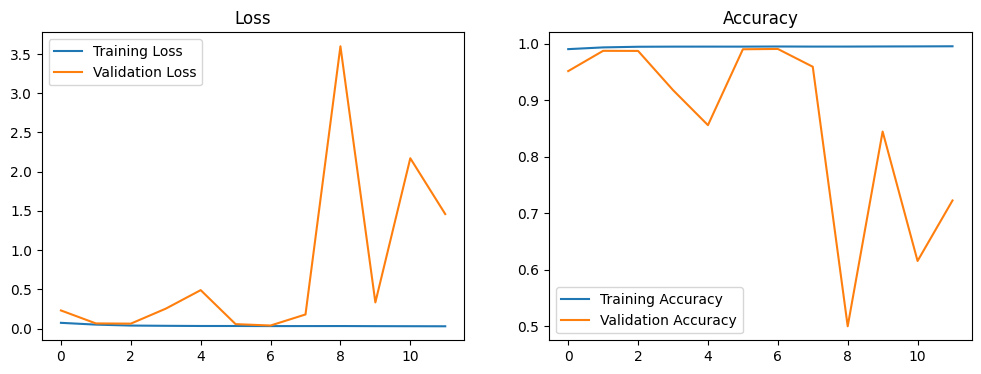

11358/11358 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step


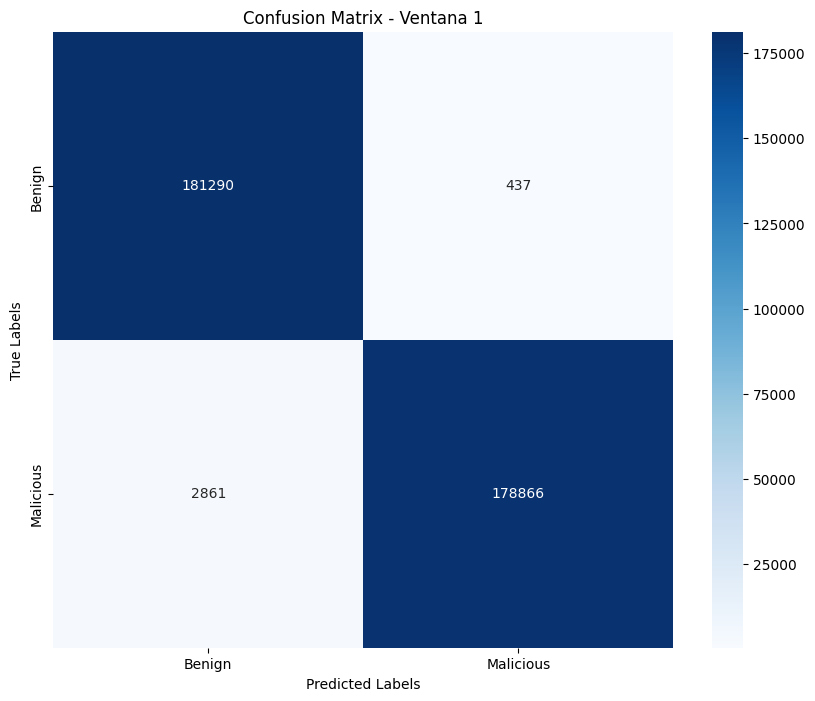


Informe de clasificación:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99    181727
   Malicious       1.00      0.98      0.99    181727

    accuracy                           0.99    363454
   macro avg       0.99      0.99      0.99    363454
weighted avg       0.99      0.99      0.99    363454

Falsos Positivos por clase (respecto a la clase):
Benign: 2861 (1.55%)
Malicious: 437 (0.24%)

Falsos Negativos por clase (respecto a la clase):
Benign: 437 (0.24%)
Malicious: 2861 (1.57%)


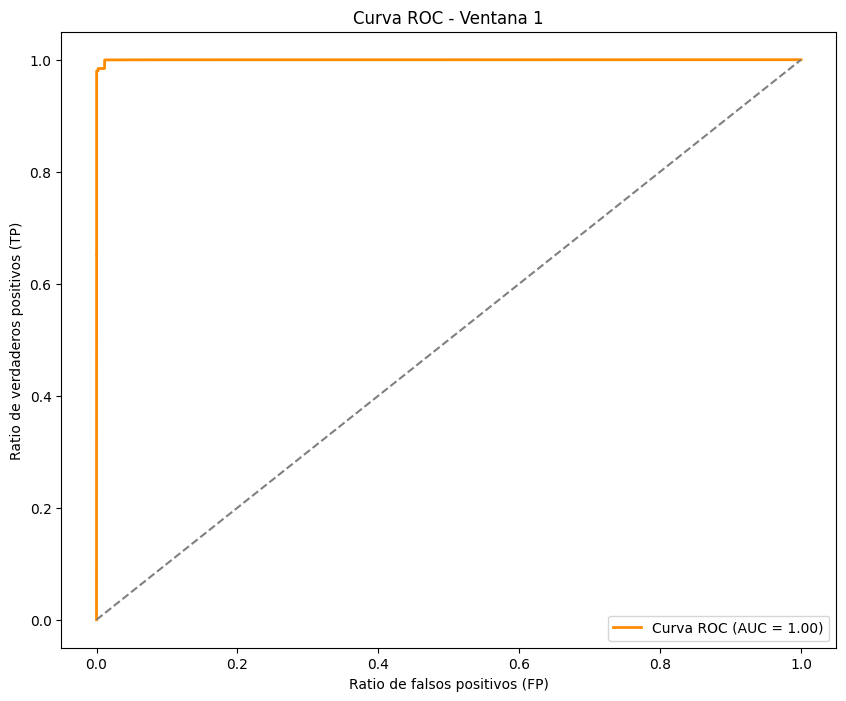




=== Entrenando modelo para ventana 2 (días 3 a 7) ===
Número de clases: 2
Clases: ['Benign' 'Malicious']


Model: "cnn_lstm_window_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 78, 8)               │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 76, 16)              │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 38, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 36, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 34, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 17, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 17, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,473 (91.69 KB)

 Trainable params: 23,409 (91.44 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
30288/30291 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.9744 - Recall: 0.9908 - accuracy: 0.9822 - loss: 0.1093
Epoch 1: val_accuracy improved from -inf to 0.98455, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_2.keras
30291/30291 ━━━━━━━━━━━━━━━━━━━━ 402s 13ms/step - Precision: 0.9744 - Recall: 0.9908 - accuracy: 0.9822 - loss: 0.1093 - val_Precision: 0.9921 - val_Recall: 0.9769 - val_accuracy: 0.9846 - val_loss: 0.1400 - learning_rate: 0.0010
Epoch 2/20
30290/30291 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.9889 - Recall: 0.9935 - accuracy: 0.9912 - loss: 0.0552
Epoch 2: val_accuracy improved from 0.98455 to 0.98583, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_2.keras
30291/30291 ━━━━━━━━━━━━━━━━━━━━ 384s 13ms/step - Precision: 0.9889 - Recall: 0.9935 - accuracy: 0.9912 - loss: 0.0552 - val_Precision: 0.9922 - val_Recall: 0.9794 - val_accuracy: 0.9858 

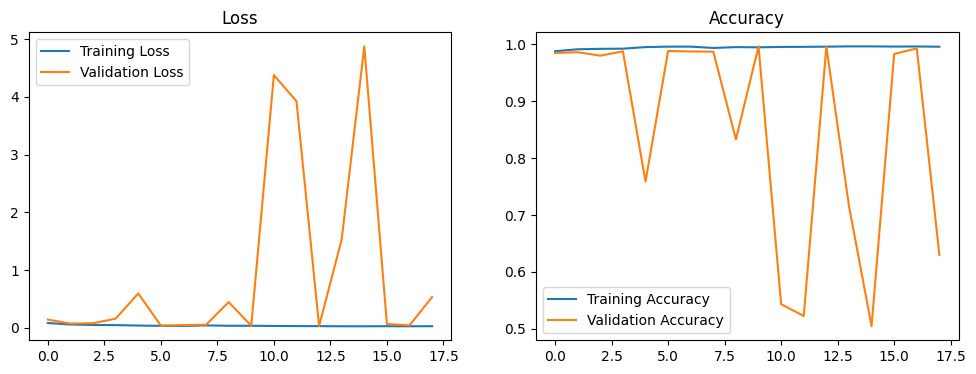

8655/8655 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step


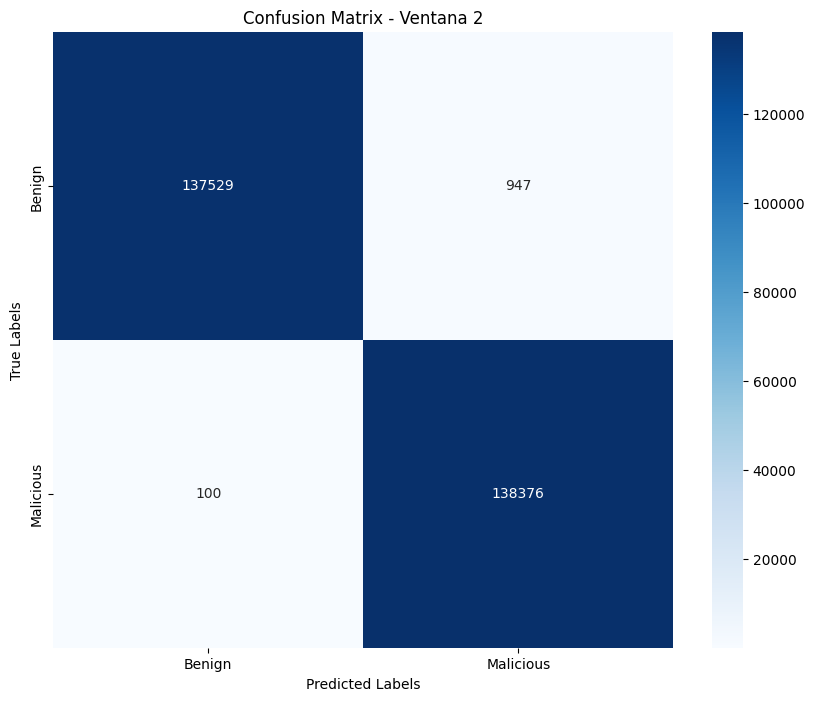


Informe de clasificación:
              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00    138476
   Malicious       0.99      1.00      1.00    138476

    accuracy                           1.00    276952
   macro avg       1.00      1.00      1.00    276952
weighted avg       1.00      1.00      1.00    276952

Falsos Positivos por clase (respecto a la clase):
Benign: 100 (0.07%)
Malicious: 947 (0.68%)

Falsos Negativos por clase (respecto a la clase):
Benign: 947 (0.68%)
Malicious: 100 (0.07%)


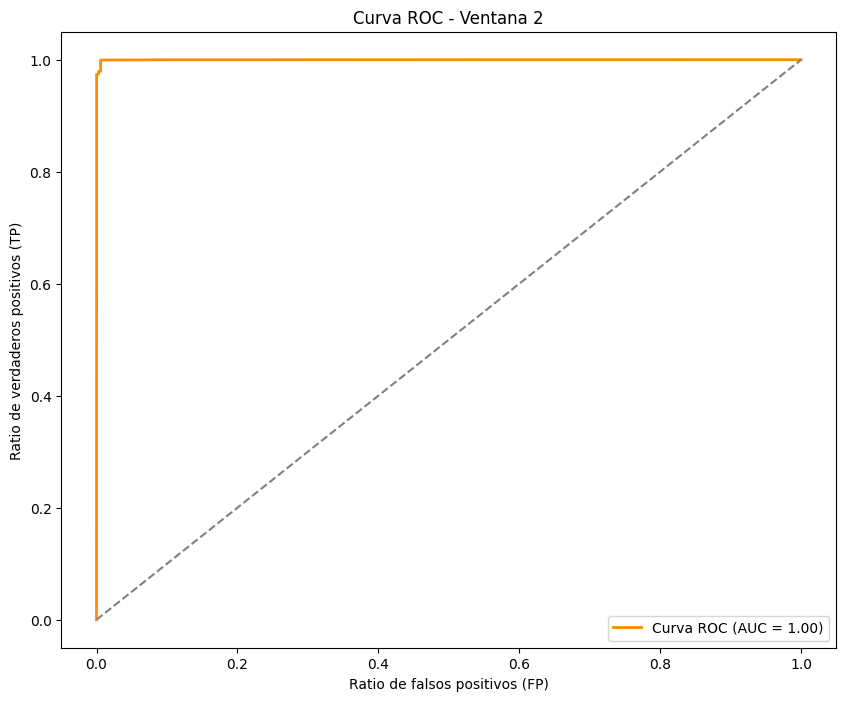




=== Entrenando modelo para ventana 3 (días 5 a 9) ===
Número de clases: 2
Clases: ['Benign' 'Malicious']


Model: "cnn_lstm_window_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 78, 8)               │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 76, 16)              │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling1D)             │ (None, 38, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 36, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 34, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling1D)             │ (None, 17, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 17, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,473 (91.69 KB)

 Trainable params: 23,409 (91.44 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
11428/11428 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Precision: 0.8511 - Recall: 0.8305 - accuracy: 0.8423 - loss: 0.2791
Epoch 1: val_accuracy improved from -inf to 0.84611, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_3.keras
11428/11428 ━━━━━━━━━━━━━━━━━━━━ 167s 14ms/step - Precision: 0.8511 - Recall: 0.8305 - accuracy: 0.8423 - loss: 0.2791 - val_Precision: 0.7654 - val_Recall: 0.9980 - val_accuracy: 0.8461 - val_loss: 0.2352 - learning_rate: 0.0010
Epoch 2/20
11427/11428 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Precision: 0.8337 - Recall: 0.8573 - accuracy: 0.8429 - loss: 0.2508
Epoch 2: val_accuracy improved from 0.84611 to 0.84612, saving model to /content/drive/My Drive/TFM - DS/output_datasets/static_window_model/cnn-lstm_window_3.keras
11428/11428 ━━━━━━━━━━━━━━━━━━━━ 163s 14ms/step - Precision: 0.8337 - Recall: 0.8573 - accuracy: 0.8429 - loss: 0.2508 - val_Precision: 0.7650 - val_Recall: 0.9991 - val_accuracy: 0.8461 

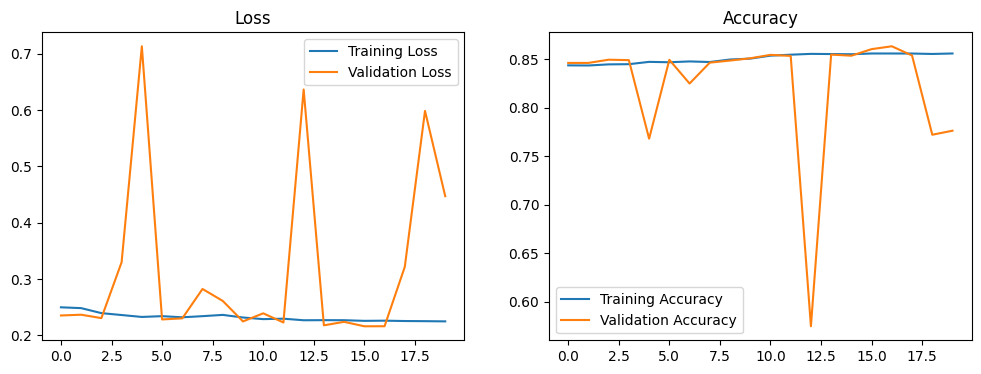

3266/3266 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


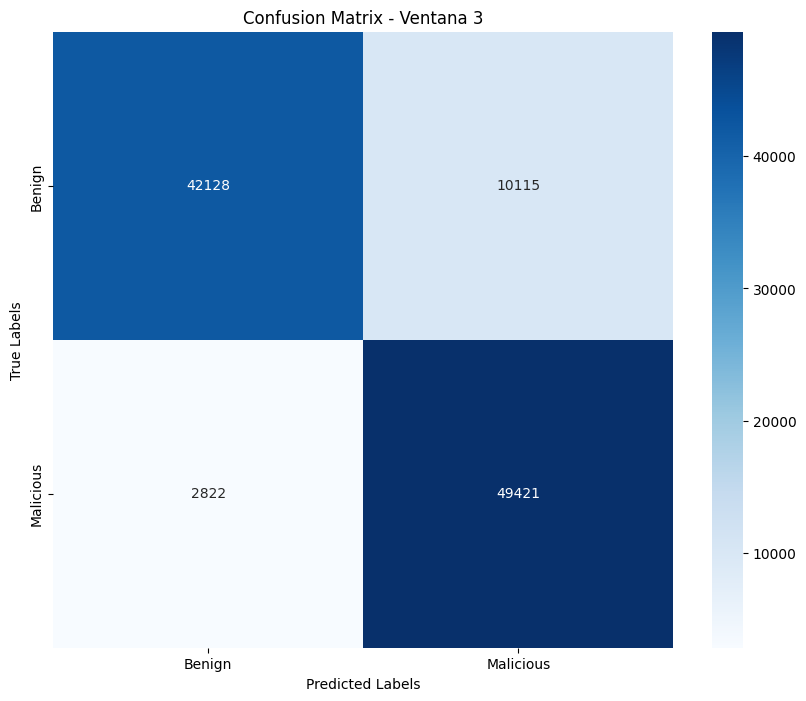


Informe de clasificación:
              precision    recall  f1-score   support

      Benign       0.94      0.81      0.87     52243
   Malicious       0.83      0.95      0.88     52243

    accuracy                           0.88    104486
   macro avg       0.88      0.88      0.88    104486
weighted avg       0.88      0.88      0.88    104486

Falsos Positivos por clase (respecto a la clase):
Benign: 2822 (6.28%)
Malicious: 10115 (16.99%)

Falsos Negativos por clase (respecto a la clase):
Benign: 10115 (19.36%)
Malicious: 2822 (5.40%)


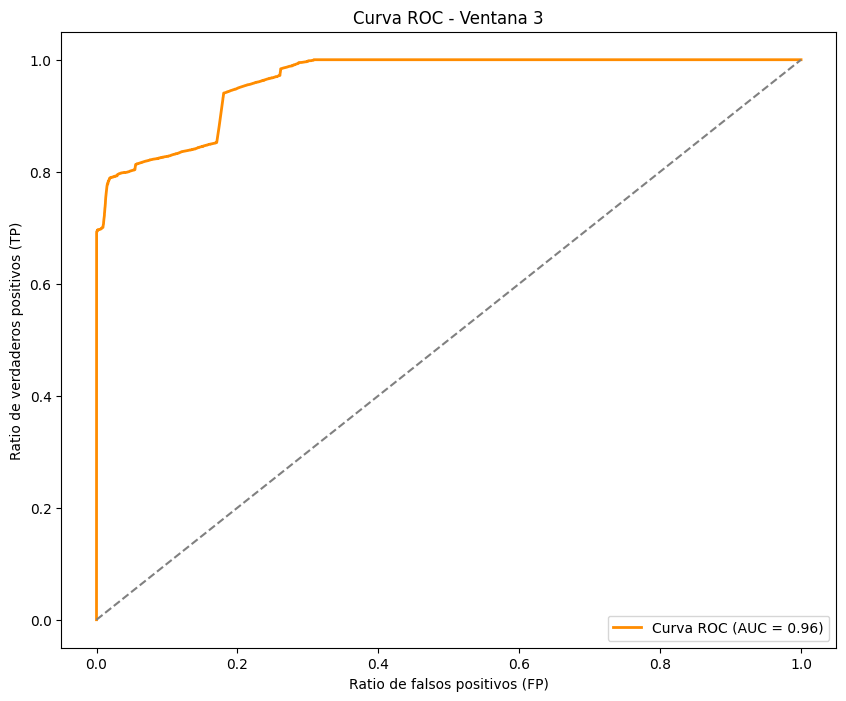

In [13]:
# Definimos el bucle principal para realizar el entrenamniento basado en ventanas deslizantes:
window_id = 1
for start_day in range(0, num_days - window_size + 1, stride):
    end_day = start_day + window_size

    # Seleccionamos los ficheros de la ventana actual:
    train_subset_files = train_files[start_day:end_day]
    val_subset_files = val_files[start_day:end_day]
    test_subset_files = test_files[start_day:end_day]

    # Cargamos y concatenamos los datos de los diferentes conjuntos de datos:
    train_dfs = [pd.read_csv(os.path.join(dataset_folder, f)) for f in train_subset_files]
    val_dfs = [pd.read_csv(os.path.join(dataset_folder, f)) for f in val_subset_files]
    test_dfs = [pd.read_csv(os.path.join(dataset_folder, f)) for f in test_subset_files]

    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True)
    test_df = pd.concat(test_dfs, ignore_index=True)

    # Procedemos a crear y entrenar el modelo correspondiente a la ventana actual:
    print(f"\n=== Entrenando modelo para ventana {window_id} (días {start_day+1} a {end_day}) ===")
    model = train_model_for_window(train_df, val_df, test_df, window_id)
    window_id += 1

    print("\n" + "="*50 + "\n")

## Paso 7: Evaluación final de los modelos respecto a el conjunto de datos completo

In [14]:
# Creamos un diccionario con todos los ficheros de prueba:
test_files = {
    '02-14-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-14-2018_test.csv'),
    '02-15-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-15-2018_test.csv'),
    '02-16-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-16-2018_test.csv'),
    '02-20-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-20-2018_test.csv'),
    '02-21-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-21-2018_test.csv'),
    '02-22-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-22-2018_test.csv'),
    '02-23-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-23-2018_test.csv'),
    '02-28-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/02-28-2018_test.csv'),
    '03-01-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-01-2018_test.csv'),
    '03-02-2018': pd.read_csv('/content/drive/My Drive/TFM - DS/output_datasets/03-02-2018_test.csv')
}

In [15]:
# Obtenemos la lista de modelos guardados en el entrenamiento anterior:
model_files = [f for f in os.listdir(save_dir) if f.endswith('.keras')]
model_files = sorted(model_files)
print(model_files)

['cnn-lstm_window_1.keras', 'cnn-lstm_window_2.keras', 'cnn-lstm_window_3.keras']


In [16]:
# Usaremos las etiquetas de nuestro codificador:
all_classes = list(label_encoder.classes_)
n_classes = len(all_classes)

In [17]:
# Creamos un diccionario para almacenar resultados de cada modelo:
all_model_results = {}

In [18]:
# Recorremos los diferentes modelos para ir evaluando cada uno respecto al conjunto completo de test:
for model_file in model_files:
    print(f"Evaluando modelo: {model_file}")
    model_path = os.path.join(save_dir, model_file)
    model = load_model(model_path)

    # Creamos un diccionario para almacenar los resultados del modelo que se está tratando:
    test_results = {}

    # Evaluamos todos los ficheros de test de todos los días con este modelo:
    for file_name, df in test_files.items():
        print(f"Procesando fichero {file_name} con el modelo {model_file}...")

        # Separamos las variables/características (X) y las etiquetas (y):
        X_test = df.drop(columns=["Label"]).values
        y_test = df["Label"].values

        # Escalamos las características con el scaler ya entrenado al inicio del notebook:
        X_test_scaled = scaler.transform(X_test)

        # Añadimos una dimensión extra para que sea compatible con las capas Conv1D:
        X_test_reshaped = X_test_scaled[..., np.newaxis]

        # Realizamos las predicciones:
        y_pred_proba = model.predict(X_test_reshaped)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Codificamos las etiquetas del conjunto de test:
        y_test_encoded = label_encoder.transform(y_test)

        # Generamos la matriz de confusión y las métricas del informe de clasificación:
        conf_matrix = confusion_matrix(y_test_encoded, y_pred, labels=[0, 1])
        report = classification_report(
            y_test_encoded,
            y_pred,
            target_names=all_classes,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

        # Calculamos los falsos positivos (FP) y los falsos negativos (FN) respecto a la propia clase:
        false_positives_by_class = {}
        false_negatives_by_class = {}

        for i, class_name in enumerate(all_classes):
            total_predicted_for_class = np.sum(conf_matrix[:, i])
            total_actual_for_class = np.sum(conf_matrix[i, :])

            # Falsos Positivos (FP):
            fp = total_predicted_for_class - conf_matrix[i, i]
            fp_percentage = (fp / total_predicted_for_class * 100) if total_predicted_for_class > 0 else 0

            # Falsos Negativos (FN):
            fn = total_actual_for_class - conf_matrix[i, i]
            fn_percentage = (fn / total_actual_for_class * 100) if total_actual_for_class > 0 else 0

            # Guardamos los resultados:
            false_positives_by_class[class_name] = (fp, fp_percentage)
            false_negatives_by_class[class_name] = (fn, fn_percentage)

        # Almacenamos los resultados obtenidos para el fichero de test actual:
        test_results[file_name] = {
            "conf_matrix": conf_matrix,
            "classification_report": pd.DataFrame(report).transpose(),
            "y_test_encoded": y_test_encoded,
            "y_pred": y_pred,
            "false_positives": false_positives_by_class,
            "false_negatives": false_negatives_by_class
        }

        # Mostramos un resumen de los resultados:
        print(f"Resultados para {file_name} con {model_file}:")
        print("Matriz de confusión:\n", conf_matrix, "\n")
        print("Informe de clasificación:\n", pd.DataFrame(report).transpose())
        print("\nFalsos Positivos por clase (respecto a la clase):")
        for class_name, (fp, fp_percentage) in false_positives_by_class.items():
            print(f"{class_name}: {fp} ({fp_percentage:.2f}%)")

        print("\nFalsos Negativos por clase (respecto a la clase):")
        for class_name, (fn, fn_percentage) in false_negatives_by_class.items():
            print(f"{class_name}: {fn} ({fn_percentage:.2f}%)")
        print("\n" + "="*50 + "\n")

    # Guardamos los resultados de todos los ficheros para el modelo actual:
    all_model_results[model_file] = test_results

Evaluando modelo: cnn-lstm_window_1.keras
Procesando fichero 02-14-2018 con el modelo cnn-lstm_window_1.keras...
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
Resultados para 02-14-2018 con cnn-lstm_window_1.keras:
Matriz de confusión:
 [[38085    10]
 [    0 38095]] 

Informe de clasificación:
               precision    recall  f1-score       support
Benign         1.000000  0.999737  0.999869  38095.000000
Malicious      0.999738  1.000000  0.999869  38095.000000
accuracy       0.999869  0.999869  0.999869      0.999869
macro avg      0.999869  0.999869  0.999869  76190.000000
weighted avg   0.999869  0.999869  0.999869  76190.000000

Falsos Positivos por clase (respecto a la clase):
Benign: 0 (0.00%)
Malicious: 10 (0.03%)

Falsos Negativos por clase (respecto a la clase):
Benign: 10 (0.03%)
Malicious: 0 (0.00%)


Procesando fichero 02-15-2018 con el modelo cnn-lstm_window_1.keras...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Resultados para 02-15-2018 con cnn-lstm_window_1.keras:
Matriz

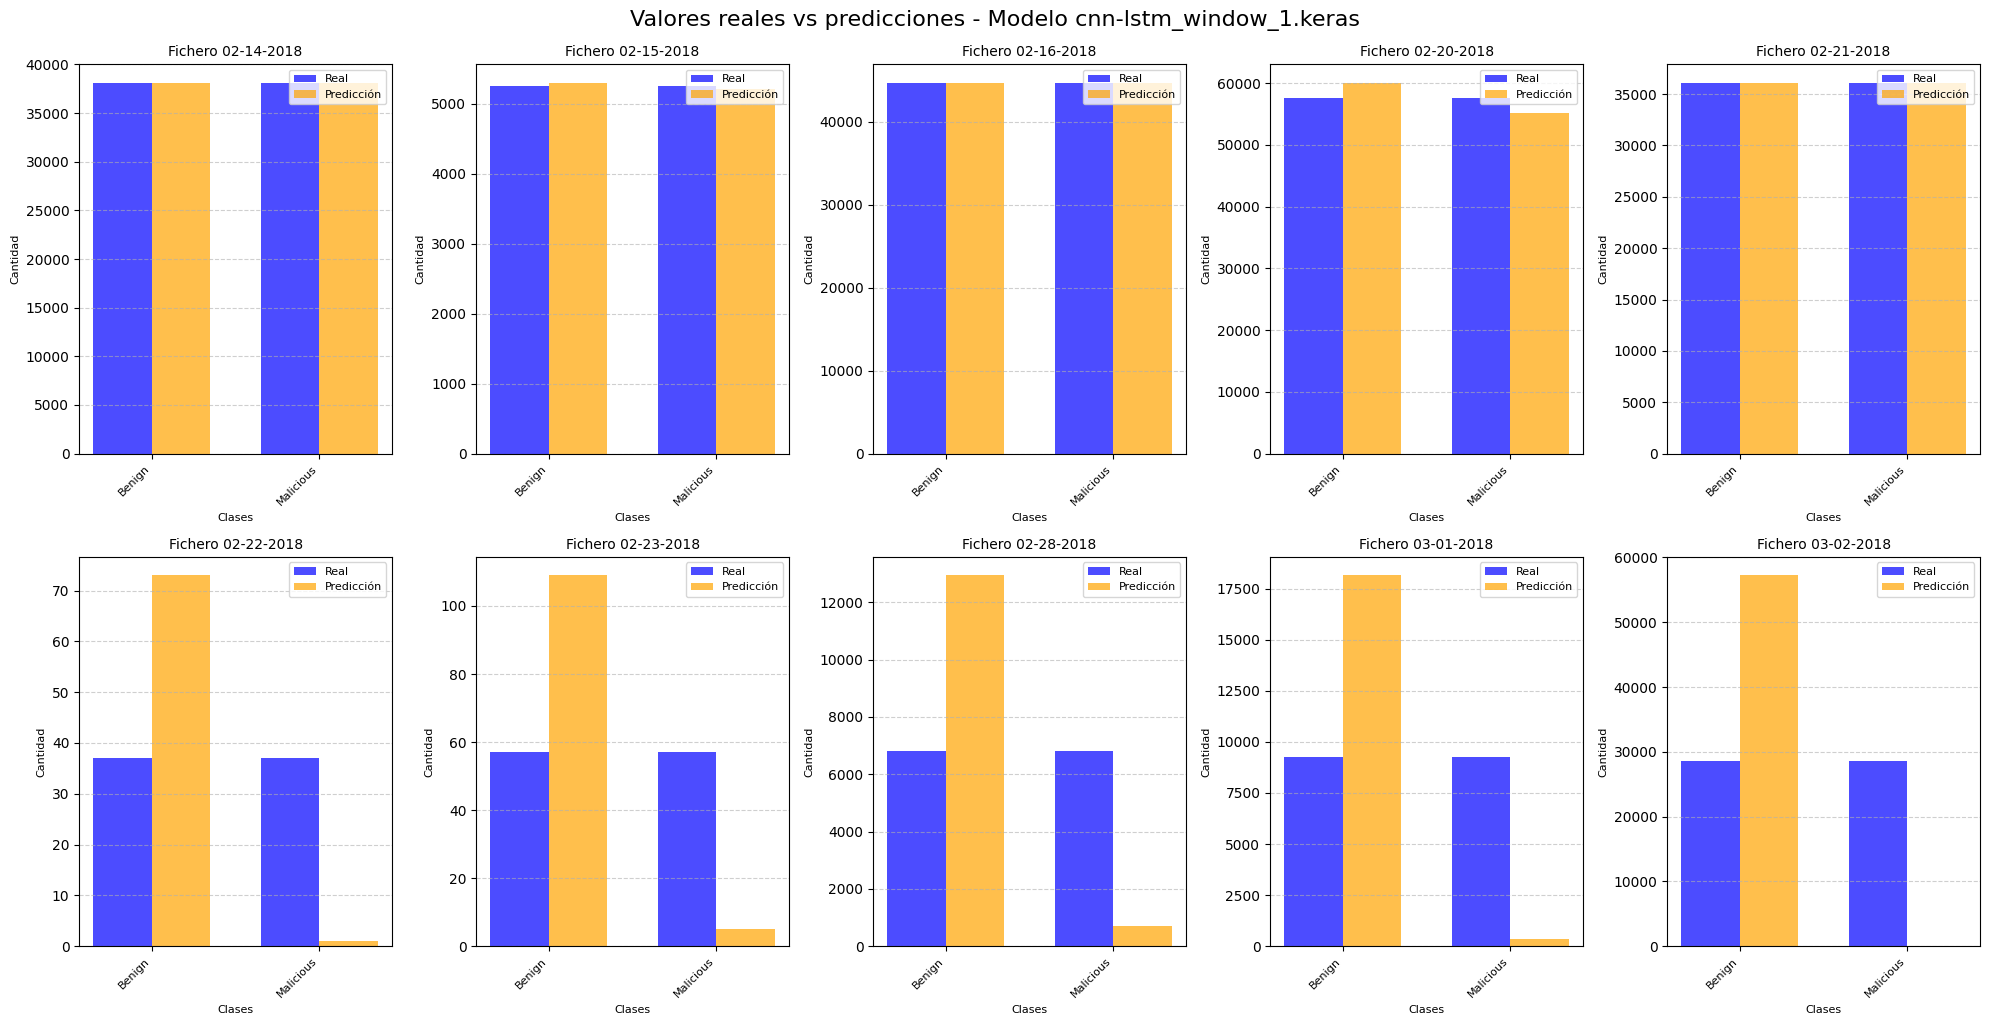

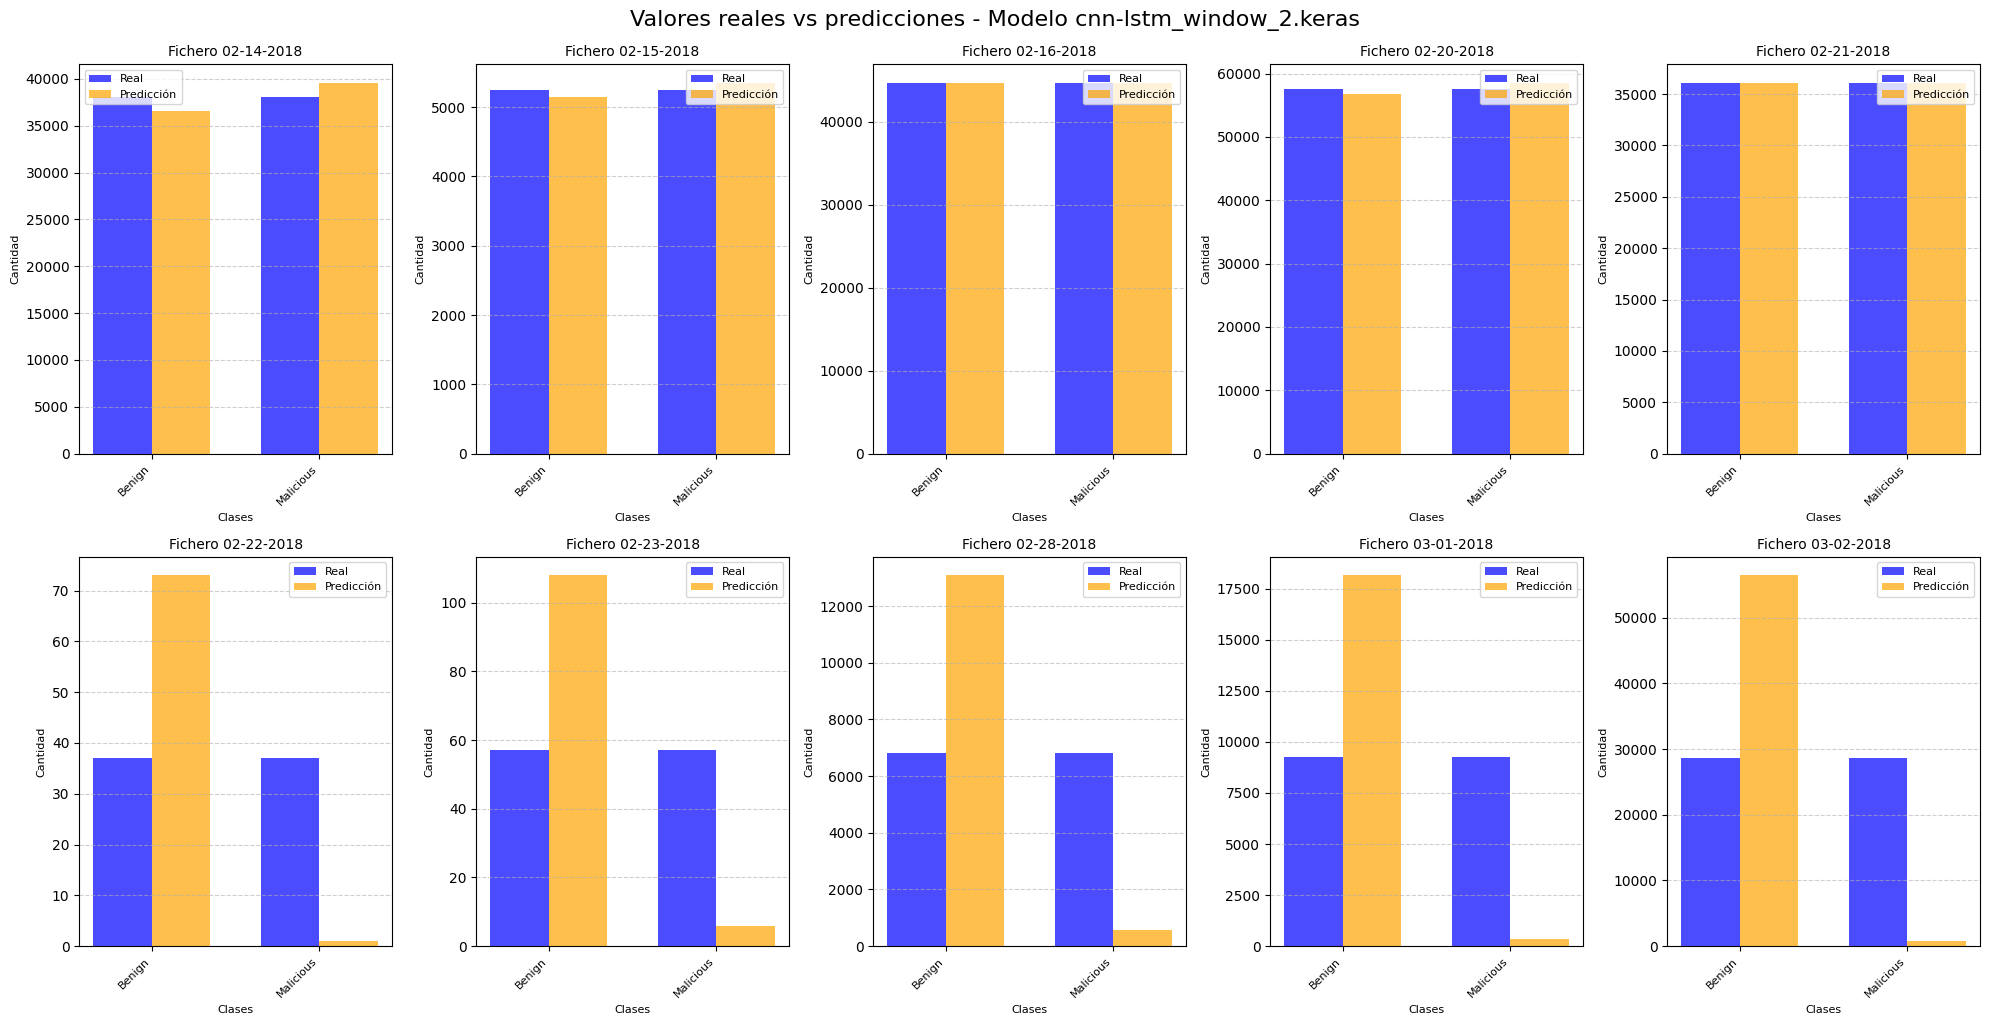

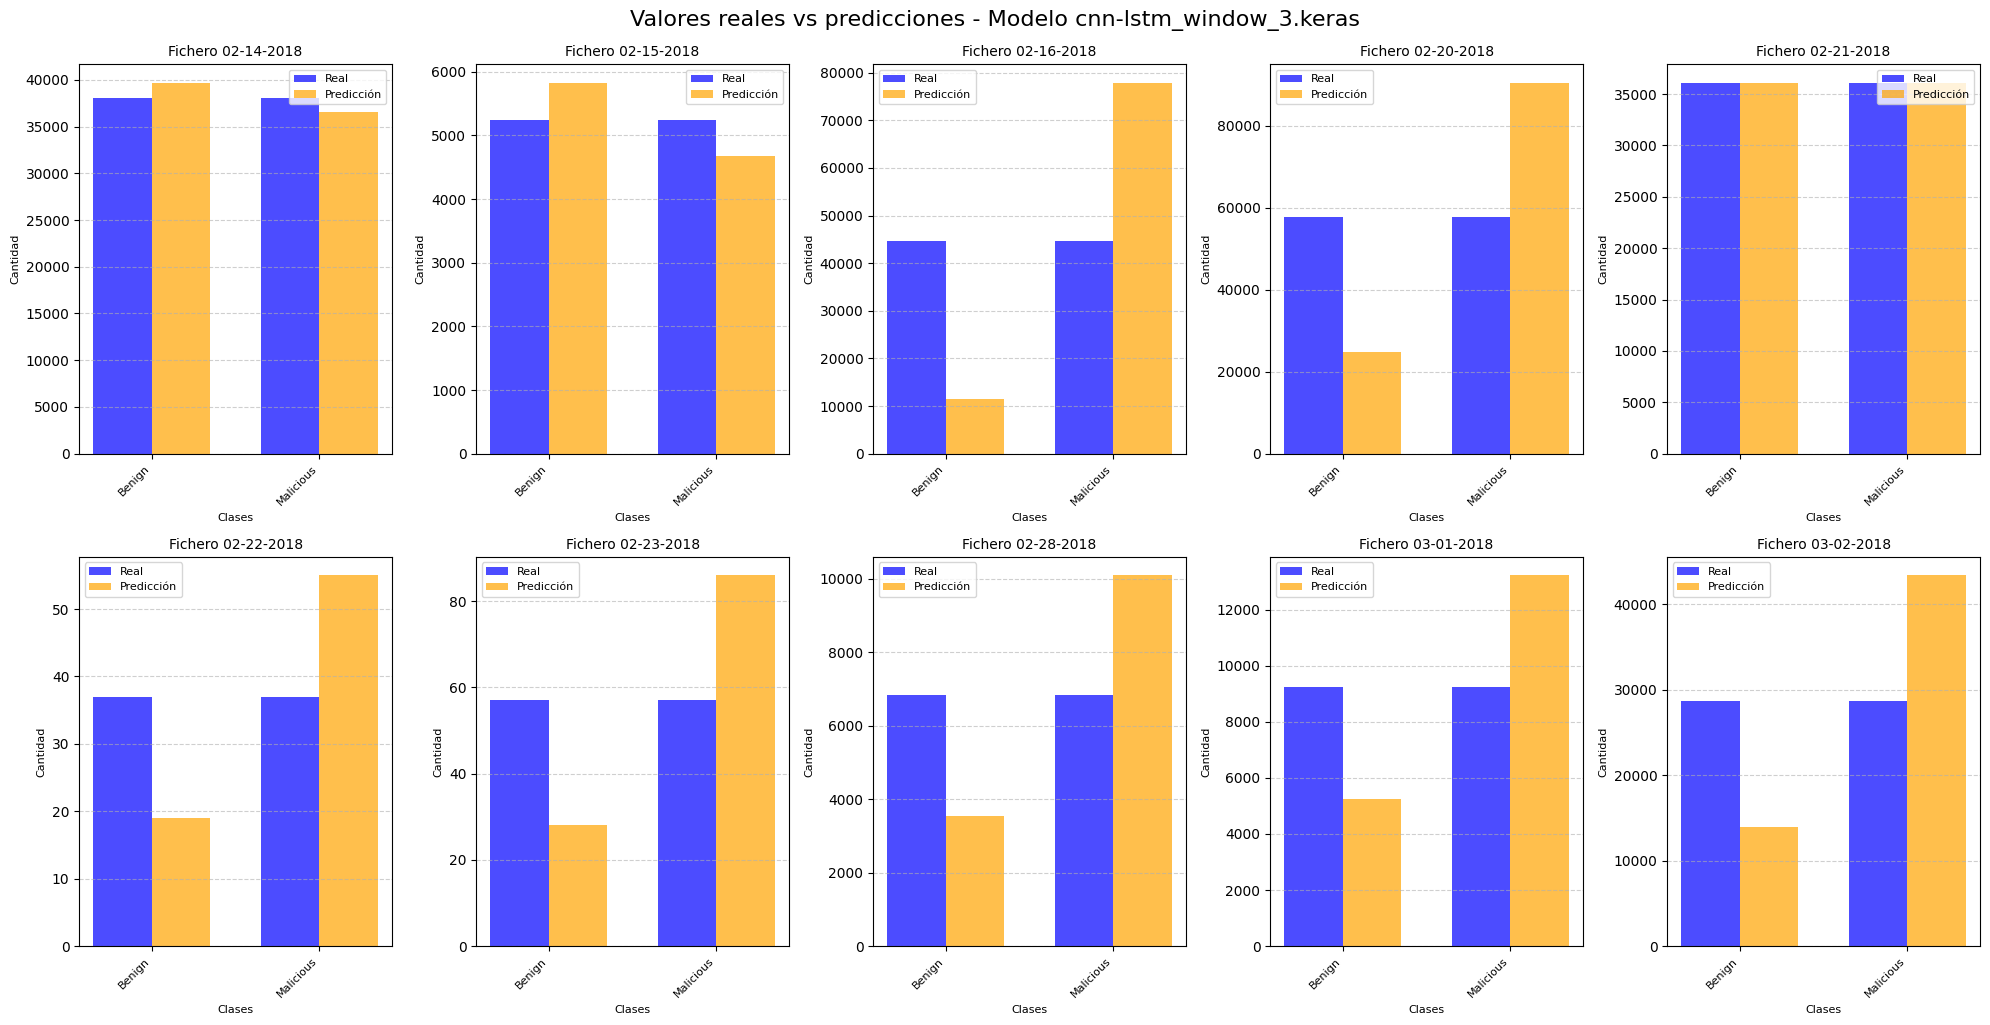

In [19]:
for model_file, test_results in all_model_results.items():
    # Creamos una figura con subplots para contener un gráfico comparativo entre valores reales versus predicciones:
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()  # Aplanar los ejes para acceder fácilmente

    # Graficamos los valores esperados vs predichos por cada fichero de test:
    for idx, (file_name, results) in enumerate(test_results.items()):
        y_test_encoded = results["y_test_encoded"]
        y_pred = results["y_pred"]

        # Realizamos el conteo de ocurrencias por cada clase:
        real_counts = np.bincount(y_test_encoded, minlength=n_classes)
        predicted_counts = np.bincount(y_pred, minlength=n_classes)

        # Creamos el gráfico en el subplot correspondiente:
        ax = axes[idx]
        x = np.arange(n_classes)
        width = 0.35

        ax.bar(x - width/2, real_counts, width, label="Real", color="blue", alpha=0.7)
        ax.bar(x + width/2, predicted_counts, width, label="Predicción", color="orange", alpha=0.7)

        # Añadimos las etiquetas y leyenda:
        ax.set_title(f"Fichero {file_name}", fontsize=10)
        ax.set_xticks(x)
        ax.set_xticklabels(all_classes, rotation=45, ha="right", fontsize=8)
        ax.set_xlabel("Clases", fontsize=8)
        ax.set_ylabel("Cantidad", fontsize=8)
        ax.legend(fontsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostramos la figura resultante:
    plt.tight_layout()
    plt.suptitle(f"Valores reales vs predicciones - Modelo {model_file}", fontsize=16, y=1.02)
    plt.show()

    print("\n")

<b>Modelo 1: conjunto de datos de entrenamiento días 1 a 5</b>

Este primer modelo es idéntico al modelo estático visto en el notebook anterior, por lo que los resultados siguen siendo los mismos. El modelo tiene un desempeño excelente en los días en los que se ha entrenado el modelo con una precisión y recall cercanos a 1.00 en la mayoría de los casos, con un porcentaje de falsos positivos y falsos negativos muy bajos, donde las clases "Benign" y "Malicious" son clasificadas correctamente con una muy buena precisión.

Durante los días que se encuentran fuera del rango de entrenamiento definido para esta prueba, el rendimiento del modelo empieza a deteriorarse significativamente, dando unos resultados muy malos y que hacen inútil el modelo para su uso.

---

<b>Modelo 2: conjunto de datos de entrenamiento días 3 a 7</b>

Tanto la pérdida como la exactitud en el entrenamiento son casi perfectos y sin apenas variación, por lo que el modelo se ajustó muy bien a los datos de entrenamiento desde el inicio. Mientras que con los datos de validación observamos una variación bastante grande a partir de ciertas épocas, aunque viéndose muy marcadas a partir de la época 8 en adelante con cambios muy bruscos.

Nuevamente, debería realizarse un estudio en mayor profundidad para tratar de mitigar este problema e intentar tener un modelo mucho más ajustado y que no sufra problemas de generalización a partir de ciertas épocas.

La matriz de confusión muestra unos resultados muy buenos, con unas tasas muy bajas de FP y FN, con un ligero desbalance hacia la clase "Malicious", dando pie a una cantidad mayor de muestras que generarían una alerta por un falso positivo en el sistema en comparación al modelo inicial. No obstante, los valores totales son muy bajos en cuanto a porcentaje como para considerarlos como un mal modelo respecto a los datos de test de los 5 días que conforman esta ventana.

La curva ROC, al igual que con el primer modelo, refleja un rendimiento casi perfecto, con un valor en la AUC de 1.00.

Aunque el modelo parezca muy bueno, nuevamente nos encontramos con el mismo problema que con el anterior, donde el modelo parece no ser tan bueno en todos los días, dando unos resultados bastante malos en general, aunque parece ser que los dos primeros días contienen ataques que muy posiblemente tengan patrones muy similares a los de los días con mayor número de muestras.

En este caso tenemos que los días 1 y 2 quedarían fuera de la ventana de entrenamiento, pero debido a la naturaleza de los ataques de fuerza bruta, DoS y DDoS tienen ciertas similitudes al tratarse de ataques que se prolongan durante un espacio de tiempo con una gran cantidad de peticiones, aunque con sus diferencias. No obstante, los días 6 y 7, que sí entraban dentro del conjunto de entrenamiento, al tener una representación tan ínfima respecto al resto de ataques dificulta que puedan ser detectados corectamente. Finalmente, los días 8 al 10, al tratarse de ataques desconocidos y sin semejanzas directas con otros ataques, parece que el modelo no es capaz de detectarlas correctamente para su clasificación.

---

<b>Modelo 3: conjunto de datos de entrenamiento días 5 a 9</b>

En este último modelo no tenemos tan buenos resultados como en los anteriores, con una pérdida y exactitud estables y bastante buenos durante el entrenamiento, pero sin llegar a los niveles de los modelos anteriores. En los datos de validación volvemos a tener una variación alta desde casi el inicio, concambios bastante bruscos durante todo el entrenamiento.

Cabe destacar nuevamente la necesidad de analizar en mayor profundidad este problema para tratar de mitigarlo mejorando el modelo actual. Como se ha comentado, se ha utilizado un modelo con un buen resultado en un artículo de investigación, sin añadir grandes cambios en general, para poder comprobar si realmente las ventanas deslizantes pueden ser una opción a tener en cuenta en un entorno de producción de un sistema IDS.

Los resultados obtenidos en la matriz de confusión con el conjunto de test, así como en el informe de clasificación muestran un aumento muy grande en la cantidad de muestras benignas que se han determinado como maliciosas (FP = 16.99%), lo que indica que el modelo da pie a una cantidad muy grande de alertas que no deberían tratarse al ser falsos positivos.

Por otro lado, la cantidad de falsos negativos ha aumentado bastante también (FN = 5.40%), lo que indica que una cantidad considerable de ataques pasan desapercibidos al no ser detectados correctamente.

Aunque el valor de la AUC es bastante alto (cerca del 0.96), indicando que el modelo tiene un buen rendimiento general para separar las clases, vemos que no sería el idóneo para un sistema IDS en un entorno de producción debido a la cantidad de FP y FN que este modelo devuelve.

Precisamente las mayores carencias las observamos en el rendimiento del modelo respecto a los diferentes ficheros.

A simple vista podemos ver que hay una enorme cantidad de falsos positivos en la gran mayoría de los días, lo que hace que este modelo no sea bueno para usarlo en un entorno productivo, más allá del aumento considerable que también tenemos en el número de falsos negativos.

Llegados a este punto podemos constatar que el sistema de entrenamiento por ventanas deslizantes, aunque pueda ser muy buena idea y ser funcional en muchos casos, no resulta del todo eficaz en problemáticas como un sistema IDS que quiera poder aprwnder nuevos patrones sin perder el conocimiento previo. Más allá de los nuevos ataques que van apareciendo a lo largo del tiempo, hay que tener en cuenta que los ataques antiguos no tienen porque dejar de usarse, simplemente hay épocas en las que se utilizan más una tipología de ataque que otra, pudiendo volver a hacerse populares ataques antiguos o variaciones de los mismos. En este caso, un ataque antiguo no sería bien detectado si no se encuentran ataques similares dentro del conjunto de entrenamiento de la ventana deslizante correspondiente, como vemos, en este caso, con los resultados en las predicciones para los días 3 y 4, donde una gran parte de las muestras son consideradas como maliciosas.